# 糖尿病患者預測

資料處理流程：
1. EDA
2. 遺漏值填補(平均值或是中位數)
3. 選擇分類方法
4. 特徵選擇
5. PCA & LDA

In [1]:
#基礎資料操作與視覺化
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#忽略警告，為了排版整齊
warnings.filterwarnings('ignore')

#選擇圖形樣式
%matplotlib inline
plt.style.use('fivethirtyeight')

#遺漏值填補
from sklearn.impute import SimpleImputer

#機器學習管線
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#標準化與正規劃
from sklearn.preprocessing import StandardScaler

#機器學習分類方法
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#自定義管線內容
from sklearn.base import TransformerMixin, BaseEstimator
from copy import deepcopy

#特徵選擇
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel

#特徵轉換
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Exploratory Data Analysis

### 載入檔案

In [2]:
pima = pd.read_csv('./data/pima.data.csv')
pima.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


### 欄位名稱
- times_pregnant: 懷孕次數
- plasma_glucose_concentration: 口服葡萄糖耐量試驗中的2小時血漿葡萄糖濃度
- diastolic_blood_pressure: 舒張壓 (mmHg)
- triceps_thickness: 三頭肌皮脂厚度 (mm)
- serum_insulin: 2小時血清胰島素濃度 (U/ml)
- bmi: 身體質量指數
- pedigree_function: 糖尿病家族函數
- age: 年齡
- 類別變數(0或1，代表無或有糖尿病)
> 利用8個特徵預測是否有糖尿病，8個特徵都是屬於__Metric尺度__

In [3]:
#加入title
pima_column_names = ['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness', 'serum_insulin', 'bmi', 'pedigree_function', 'age', 'onset_diabetes']
pima = pd.read_csv('./data/pima.data.csv', names=pima_column_names)
pima.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 觀察空準確率
null accuracy表示我們全部只猜類別多的那一類，正確的機率會是多少

In [4]:
pima['onset_diabetes'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: onset_diabetes, dtype: float64

> 什麼都不做，accuracy就至少要有65%正確率

### 觀察直方圖
藉由直方圖觀察哪些變數對於分離是否為糖尿病患者有利

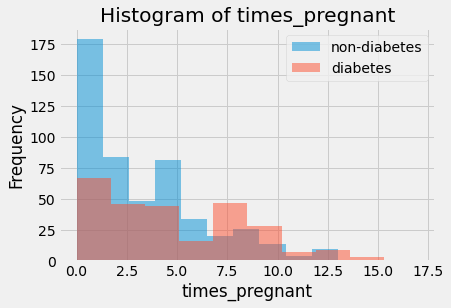

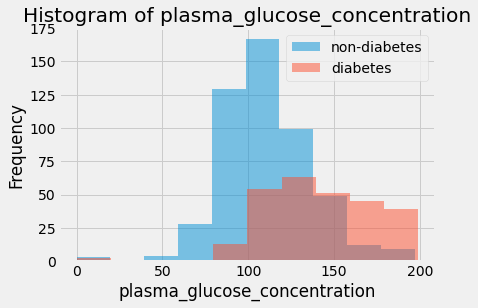

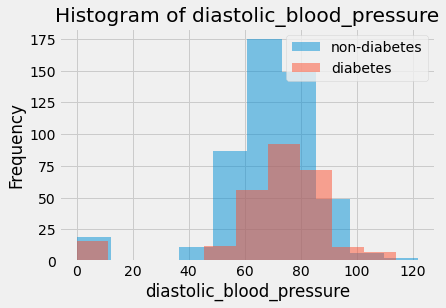

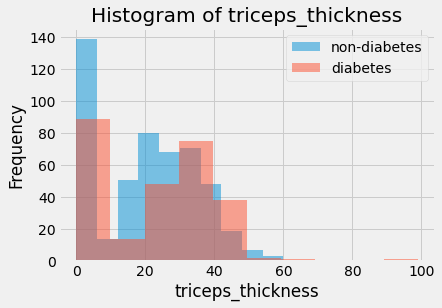

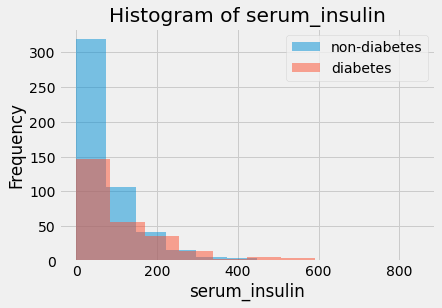

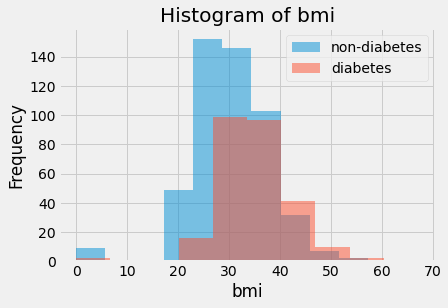

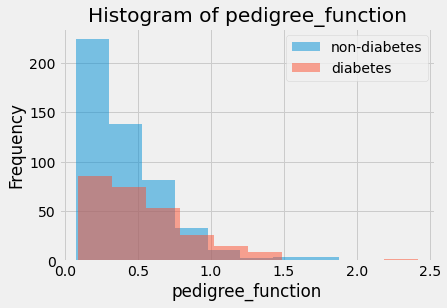

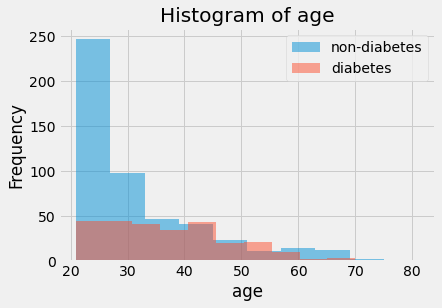

In [5]:
for col in pima_column_names[:-1]:
    plt.hist(pima[pima['onset_diabetes']==0][col], 10, alpha=0.5, label="non-diabetes")
    plt.hist(pima[pima['onset_diabetes']==1][col], 10, alpha=0.5, label="diabetes")
    
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

> 就圖形結果觀察，plasma_glucose_concertration對於分離是否為糖尿病有幫助

### 相關分析
藉由數值及圖形來判斷特徵與反應變數的相關程度

<AxesSubplot:>

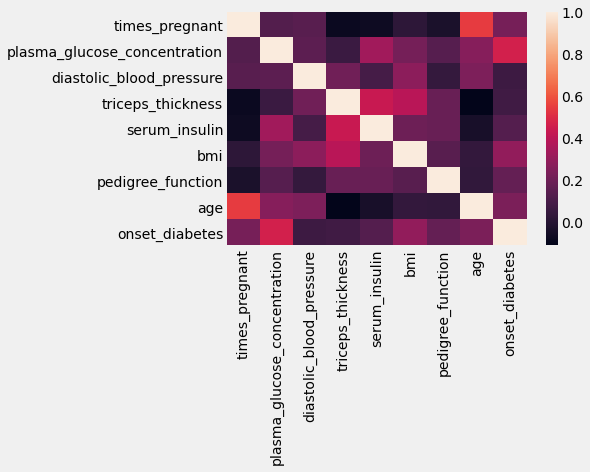

In [6]:
# 相關矩陣熱區圖

sns.heatmap(pima.corr())

In [7]:
# 相關係數
pima.corr()['onset_diabetes']

times_pregnant                  0.221898
plasma_glucose_concentration    0.466581
diastolic_blood_pressure        0.065068
triceps_thickness               0.074752
serum_insulin                   0.130548
bmi                             0.292695
pedigree_function               0.173844
age                             0.238356
onset_diabetes                  1.000000
Name: onset_diabetes, dtype: float64

> plasma_glucose_concentration與onset_diabetes相關係數最高，屬於重要的變數

## 遺漏值填補

### 觀察遺漏值情況

In [8]:
pima.isnull().sum()

times_pregnant                  0
plasma_glucose_concentration    0
diastolic_blood_pressure        0
triceps_thickness               0
serum_insulin                   0
bmi                             0
pedigree_function               0
age                             0
onset_diabetes                  0
dtype: int64

> 沒有遺漏值，但有可能是因為原先的資料利用其他方法表示遺漏值，例如用0表示遺漏值

In [9]:
#描述性統計
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


> 發現到times_pregnant、plasma_glucose_concentration、diastolic_blood_pressure、triceps_thickness、serum_insulin、bmi、onset_diabetes這些欄位最小值為0。有些欄位可以是0，但有些不可以。

- 可以為0: onset_diabetes=0代表沒有糖尿病，times_pregnant=0代表沒有懷過孕

- 不可為0: plasma_glucose_concentration(葡萄糖濃度不可能為0)、diastolic_blood_pressure(舒張壓不可能為0)、triceps_thickness(三頭肌皮脂厚度不可為0)、serum_insulin(血清胰島素濃度不可為0)、bmi(身高體重不可能為0)

### 替換遺漏值

In [10]:
columns = ['serum_insulin', 'bmi', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness']

for col in columns:
    pima[col].replace([0], [None], inplace=True)

In [11]:
# 再一次遺漏值觀察
pima.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

### 平均值填補
將遺漏值以平均值填補後，再利用機器學習分類方法觀察填補成效。比較不同的填補方法，看哪個方法較好。選擇「決策樹」作為分類模型。

In [12]:
#決策樹參數
tree_params = {'classify__max_depth':[None, 1, 3, 5, 7]}

d_tree = DecisionTreeClassifier()

#建立pipeline
mean_impute = Pipeline([('impute', SimpleImputer(strategy='mean')), ('classify', d_tree)])

X = pima.drop('onset_diabetes', axis=1)
y = pima['onset_diabetes']

grid = GridSearchCV(mean_impute, tree_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

0.7409387997623291 {'classify__max_depth': 5}


### 中位數填補

In [13]:
#決策樹參數
tree_params = {'classify__max_depth':[None, 1, 3, 5, 7]}

d_tree = DecisionTreeClassifier()

#建立pipeline
mean_impute = Pipeline([('impute', SimpleImputer(strategy='median')), ('classify', d_tree)])

X = pima.drop('onset_diabetes', axis=1)
y = pima['onset_diabetes']

grid = GridSearchCV(mean_impute, tree_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

0.7513538748832866 {'classify__max_depth': 5}


> 利用__中位數__填補成效較佳。

In [14]:
#利用中位數填補
imputer = SimpleImputer(strategy='median')

pima_imputed = imputer.fit_transform(pima)

pima_imputed = pd.DataFrame(pima_imputed, columns=pima_column_names)

pima_imputed.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


## 機器學習方法選擇
用多個機器方法嘗試，選擇成效最好的那個，成效觀察包含Accuracy、最佳參數、訓練時間、預測時間。
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Random Forest

### 最佳模型選擇

In [15]:
def get_best_model_and_accuracy(model, params, X, y):
    
    grid = GridSearchCV(model,
                       params,
                       error_score=0.)
    grid.fit(X, y)
    
    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

### 設定X與y值

In [16]:
X = pima_imputed.drop('onset_diabetes', axis=1)
y = pima_imputed['onset_diabetes']

### Logistic Regression

In [17]:
lr_params = {'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1','l2']}

lr = LogisticRegression()

get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.7617774382480265
Best Parameters: {'C': 1.0, 'penalty': 'l2'}
Average Time to Fit (s): 0.01
Average Time to Score (s): 0.001


### K-Nearest Neighbors

KNN是依照歐幾里德距離進行預測，所以在非標準化的資料上可能會失效。所以要先進行標準化再做分類，建立管線。

In [18]:
knn_params = {'n_neighbors':[1, 3, 5, 7]}

knn_pipe_params = {'classifier__{}'.format(k):v for k, v in knn_params.items()}

knn = KNeighborsClassifier()

knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])

get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

Best Accuracy: 0.7422205245734658
Best Parameters: {'classifier__n_neighbors': 7}
Average Time to Fit (s): 0.004
Average Time to Score (s): 0.007


### Decision Tree

In [19]:
tree_params = {'max_depth':[None, 1, 3, 5, 7]}

d_tree = DecisionTreeClassifier()

get_best_model_and_accuracy(d_tree, tree_params, X, y)

Best Accuracy: 0.7487479840421016
Best Parameters: {'max_depth': 5}
Average Time to Fit (s): 0.003
Average Time to Score (s): 0.002


### Random Forest

In [20]:
forest_params = {'n_estimators':[10, 50, 100], 'max_depth':[None, 1, 3, 5, 7]}

forest = RandomForestClassifier()

get_best_model_and_accuracy(forest, forest_params, X, y)

Best Accuracy: 0.7669977081741788
Best Parameters: {'max_depth': None, 'n_estimators': 50}
Average Time to Fit (s): 0.07
Average Time to Score (s): 0.005


> 以__Random Forest__分類效果最佳，以此模型為分類模型。Accuracy: 0.7669977081741788

## 特徵選擇
- 基於統計方法: Pearson相關係數、假設檢定(ANOVA)
- 基於機器學習: 決策樹、線性模型與正規化

### Pearson相關係數特徵選取
利用自己定義相關係數特徵選取的class，以建立在管線中。

In [21]:
class CustomerCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        self.response = response
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep
        
    def transform(self, X):
        return(X[self.cols_to_keep])
    
    def fit(self, X, *_):
        df = pd.concat([X, self.response], axis=1)
        
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        
        return self

In [22]:
# 管線建立
ccc = CustomerCorrelationChooser(response=y)

ccc_pipe = Pipeline([('correlation_select', ccc), ('classifier', forest)])

ccc_pipe_params = {'correlation_select__threshold':[0, 0.1, 0.2, 0.3],
                  'classifier__n_estimators':[10, 50, 100],
                  'classifier__max_depth':[None, 1, 3, 5, 7]}

get_best_model_and_accuracy(ccc_pipe, ccc_pipe_params, X, y)

Best Accuracy: 0.7708938120702827
Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'correlation_select__threshold': 0.2}
Average Time to Fit (s): 0.072
Average Time to Score (s): 0.007


In [23]:
# 所有特徵與反應變數的相關係數
pima_imputed.corr()['onset_diabetes']

times_pregnant                  0.221898
plasma_glucose_concentration    0.492782
diastolic_blood_pressure        0.165723
triceps_thickness               0.214873
serum_insulin                   0.203790
bmi                             0.312038
pedigree_function               0.173844
age                             0.238356
onset_diabetes                  1.000000
Name: onset_diabetes, dtype: float64

In [24]:
#測試特徵選擇保留了那些特徵
ccc = CustomerCorrelationChooser(threshold=0.2, response=y)

ccc.fit(X)
print("保留特徵的相關係數")
for col in ccc.cols_to_keep:
    
    coefficient = pima_imputed.corr()['onset_diabetes'][col]
    print(col,":",coefficient)

保留特徵的相關係數
times_pregnant : 0.2218981530339883
plasma_glucose_concentration : 0.4927824039150287
triceps_thickness : 0.21487321939198917
serum_insulin : 0.2037903422445463
bmi : 0.3120383386771123
age : 0.23835598302719743


> Pearson相關係數選擇了6個特徵。Accuracy: 0.7708938120702827

### 假設檢定
運用ANOVA，計算P-value去觀察各個特徵是否對於反應變數的分辨有意義。

In [25]:
k_best = SelectKBest(f_classif, k=5)
k_best.fit_transform(X, y)


#按照p-value排序
p_values = pd.DataFrame({'column':X.columns, 'p_value':k_best.pvalues_}).sort_values('p_value')
p_values

,column,p_value
1,plasma_glucose_concentration,3.128719e-48
5,bmi,8.336903e-19
7,age,2.209975e-11
0,times_pregnant,5.065127e-10
3,triceps_thickness,1.793958e-09
4,serum_insulin,1.210026e-08
6,pedigree_function,1.254607e-06
2,diastolic_blood_pressure,3.890835e-06


In [26]:
# 管線建立
k_best = SelectKBest(f_classif)

select_k_pipe = Pipeline([('k_best', k_best), ('classifier', forest)])

select_k_pipe_params = {'k_best__k':list(range(1,8))+['all'],
                        'classifier__n_estimators':[10, 50, 100],
                        'classifier__max_depth':[None, 1, 3, 5, 7]}

get_best_model_and_accuracy(select_k_pipe, select_k_pipe_params, X, y)

Best Accuracy: 0.7787029963500551
Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'k_best__k': 4}
Average Time to Fit (s): 0.07
Average Time to Score (s): 0.006


In [41]:
# 觀察選了哪些特徵
k_best = SelectKBest(f_classif, k=4)
k_best.fit_transform(X, y)
p_values = pd.DataFrame({'column':X.columns, 'p_value':k_best.pvalues_}).sort_values('p_value')

print("假設檢定選擇的特徵")
p_values.head(4)

假設檢定選擇的特徵


,column,p_value
1,plasma_glucose_concentration,3.128719e-48
5,bmi,8.336903e-19
7,age,2.209975e-11
0,times_pregnant,5.065127e-10


> 假設檢定用了4個特徵。Accuracy: 0.7787029963500551

### 決策樹

In [28]:
#建立決策樹分類器，並根據分類器觀察特徵重要程度
tree = DecisionTreeClassifier()
tree.fit(X, y)

importances = pd.DataFrame({
    'importance':tree.feature_importances_,
    'feature':X.columns
}).sort_values('importance', ascending=False)

importances

,importance,feature
1,0.320608,plasma_glucose_concentration
5,0.211892,bmi
2,0.113730,diastolic_blood_pressure
6,0.108140,pedigree_function
7,0.099559,age
4,0.079753,serum_insulin
0,0.050650,times_pregnant
3,0.015668,triceps_thickness


In [29]:
select = SelectFromModel(DecisionTreeClassifier())

select_from_pipe = Pipeline([('select', select),
                            ('classifier', forest)])


select_from_pipe_params = {'select__threshold': [.01, .05, .1, .15, "mean", "median", "2.*mean"],
                           'select__estimator__max_depth': [None, 1, 3, 5, 7],
                           'classifier__n_estimators':[10, 50, 100],
                           'classifier__max_depth':[None, 1, 3, 5, 7]}

get_best_model_and_accuracy(select_from_pipe, select_from_pipe_params, X, y)

Best Accuracy: 0.7761055937526526
Best Parameters: {'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'select__estimator__max_depth': 3, 'select__threshold': 0.05}
Average Time to Fit (s): 0.068
Average Time to Score (s): 0.006


In [42]:
#觀察使用了哪些特徵
select_from_pipe.set_params(**{'classifier__max_depth': 5,
                               'classifier__n_estimators': 100,
                               'select__estimator__max_depth': 3,
                               'select__threshold': 0.05})

select_from_pipe.steps[0][1].fit(X, y)

print("決策樹選擇的特徵")
X.columns[select_from_pipe.steps[0][1].get_support()]

決策樹選擇的特徵


Index(['plasma_glucose_concentration', 'bmi', 'age'], dtype='object')

> 決策樹選擇了3個特徵，分別為plasma_glucose_concentration、bmi與age。Accuracy: 0.7761055937526526。

### 線性模型 Logistic Regression中的L1 L2正規化

In [31]:
logistic_selector = SelectFromModel(LogisticRegression())

regularization_pipe = Pipeline([('select', logistic_selector),
                               ('classifier', forest)])

regularization_pipe_params = {'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
                              'select__estimator__penalty':['l1', 'l2'],
                              'classifier__n_estimators':[10, 50, 100],
                              'classifier__max_depth':[None, 1, 3, 5, 7]}

get_best_model_and_accuracy(regularization_pipe, regularization_pipe_params, X, y)

Best Accuracy: 0.7604278074866311
Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'select__estimator__penalty': 'l2', 'select__threshold': 0.01}
Average Time to Fit (s): 0.041
Average Time to Score (s): 0.003


In [43]:
# 觀察選擇了哪些特徵
regularization_pipe.set_params(**{'classifier__max_depth': None,
                                  'classifier__n_estimators': 100,
                                  'select__estimator__penalty': 'l2',
                                  'select__threshold': 0.01})

regularization_pipe.steps[0][1].fit(X, y)


print("正規化保留的特徵")
X.columns[regularization_pipe.steps[0][1].get_support()]

正規化保留的特徵


Index(['times_pregnant', 'plasma_glucose_concentration',
       'diastolic_blood_pressure', 'bmi', 'pedigree_function', 'age'],
      dtype='object')

> 正規化選擇了6個特徵。Accuracy: 0.7604278074866311。

## 特徵轉換

將資料縮放、PCA與LDA加入到Pipeline中。

### 應用特徵選取完的特徵做轉換
__假設檢定__ 所選擇的特徵Accuracy最高，因此使用假設檢定特徵選擇的結果。

In [44]:
selected_columns = ['plasma_glucose_concentration', 'bmi', 'age','times_pregnant','onset_diabetes']

pima_imputed_selected = pd.DataFrame(pima_imputed, columns=selected_columns)

X = pima_imputed_selected.drop('onset_diabetes', axis=1)
y = pima_imputed_selected['onset_diabetes']

X.head()

,plasma_glucose_concentration,bmi,age,times_pregnant
0,148.0,33.6,50.0,6.0
1,85.0,26.6,31.0,1.0
2,183.0,23.3,32.0,8.0
3,89.0,28.1,21.0,1.0
4,137.0,43.1,33.0,0.0


In [45]:
#設定參數
pima_transform_params = {
    'preprocessing__scale__with_std':[True, False],
    'preprocessing__scale__with_mean':[True, False],
    'preprocessing__pca__n_components':[1,2,3,4],
    'preprocessing__lda__n_components':[1,2],
    'classifier__n_estimators':[10, 50, 100],
    'classifier__max_depth':[None, 1, 3, 5, 7]
}

In [46]:
#預處理管線
preprocessing = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('lda', LinearDiscriminantAnalysis())
])

#建立完整管線
pima_transform_pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                                         ('classifier', forest)])

In [47]:
get_best_model_and_accuracy(pima_transform_pipeline, pima_transform_params, X, y)

Best Accuracy: 0.7695696460402343
Best Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'preprocessing__lda__n_components': 1, 'preprocessing__pca__n_components': 3, 'preprocessing__scale__with_mean': False, 'preprocessing__scale__with_std': True}
Average Time to Fit (s): 0.032
Average Time to Score (s): 0.003


> 特徵選取加轉換，Accuracy: 0.7695696460402343。

### 用所有特徵做轉換

In [37]:
X = pima_imputed.drop('onset_diabetes', axis=1)
y = pima_imputed['onset_diabetes']

X.head()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


In [38]:
#設定參數
pima_transform_params = {
    'preprocessing__scale__with_std':[True, False],
    'preprocessing__scale__with_mean':[True, False],
    'preprocessing__pca__n_components':[1,2,3,4],
    'preprocessing__lda__n_components':[1,2],
    'classifier__n_estimators':[10, 50, 100],
    'classifier__max_depth':[None, 1, 3, 5, 7]
}

In [39]:
#預處理管線
preprocessing = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('lda', LinearDiscriminantAnalysis())
])

#建立完整管線
pima_transform_pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                                         ('classifier', forest)])

In [40]:
get_best_model_and_accuracy(pima_transform_pipeline, pima_transform_params, X, y)

Best Accuracy: 0.7552584670231729
Best Parameters: {'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'preprocessing__lda__n_components': 1, 'preprocessing__pca__n_components': 3, 'preprocessing__scale__with_mean': False, 'preprocessing__scale__with_std': False}
Average Time to Fit (s): 0.034
Average Time to Score (s): 0.003


> 全部特徵特徵轉換。Accuracy: 0.7552584670231729